In [1]:
import matplotlib as mpl
#mpl.use('Agg')
from scipy.io import netcdf
import matplotlib
#from numpy import *
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import datetime
from datetime import date
from pylab import *
import xarray
%matplotlib inline

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

#from mpl_toolkits.basemap import Basemap

In [ ]:
# Let's load Dask to make Xarray more efficient
import dask.distributed as dsk

# Start client
clnt = dsk.Client()
clnt

#### Data is not yet ready for this, hopefully on Monday!

In [2]:
#fnameu = '/g/data/rt52/era5/pressure-levels/reanalysis/u/2022/u_era5_oper_pl_20220301-20220331.nc'
#fnamev = '/g/data/rt52/era5/pressure-levels/reanalysis/v/2022/v_era5_oper_pl_20220301-20220331.nc'

datadir = '/scratch/v45/dr4292/pressure_levels/'

fname_u = 'u_component_of_wind_on_pressure_levels_20220222T0000.nc'
fname_v = 'v_component_of_wind_on_pressure_levels_20220222T0000.nc'

In [5]:
ds = xarray.open_dataset(f'{datadir}/{fname_v}')
ds

<xarray.Dataset>
Dimensions:         (latitude: 2120, longitude: 2600, time: 1,
                     pressure_level: 19)
Coordinates:
  * latitude        (latitude) float32 -48.79 -48.77 -48.75 ... -6.852 -6.832
  * longitude       (longitude) float32 107.5 107.5 107.6 ... 158.9 159.0 159.0
  * time            (time) datetime64[ns] 2022-02-22T01:00:00
  * pressure_level  (pressure_level) float32 100.0 500.0 ... 9.25e+04 1e+05
Data variables:
    y_wind          (time, pressure_level, latitude, longitude) float32 ...

In [22]:
ds = xarray.open_dataset(f'{datadir}/{fname_u}')
u_all = ds.x_wind

lon = ds.longitude
lat = ds.latitude
levels = ds.pressure_level

u = u_all.sel(longitude=slice(146,158), latitude=slice(-36,-24), pressure_level=slice(100,101))
longitude = lon.sel(longitude=slice(146,158))
latitude = lat.sel(latitude=slice(-36,-24))
#lon2d, lat2d = np.meshgrid(longitude, latitude)

ds = xarray.open_dataset(f'{datadir}/{fname_v}')
v_all = ds.y_wind

lon = ds.longitude
lat = ds.latitude
levels = ds.pressure_level

v = v_all.sel(longitude=slice(146,158), latitude=slice(-36,-24), pressure_level=slice(100,101))

#, time=slice('2022-03-30','2022-03-30T00:30:00')
u

<xarray.DataArray 'x_wind' (time: 1, pressure_level: 1, latitude: 606,
                            longitude: 606)>
[367236 values with dtype=float32]
Coordinates:
  * latitude        (latitude) float32 -36.0 -35.98 -35.96 ... -24.04 -24.02
  * longitude       (longitude) float32 146.0 146.0 146.1 ... 158.0 158.0 158.0
  * time            (time) datetime64[ns] 2022-02-22T01:00:00
  * pressure_level  (pressure_level) float32 100.0

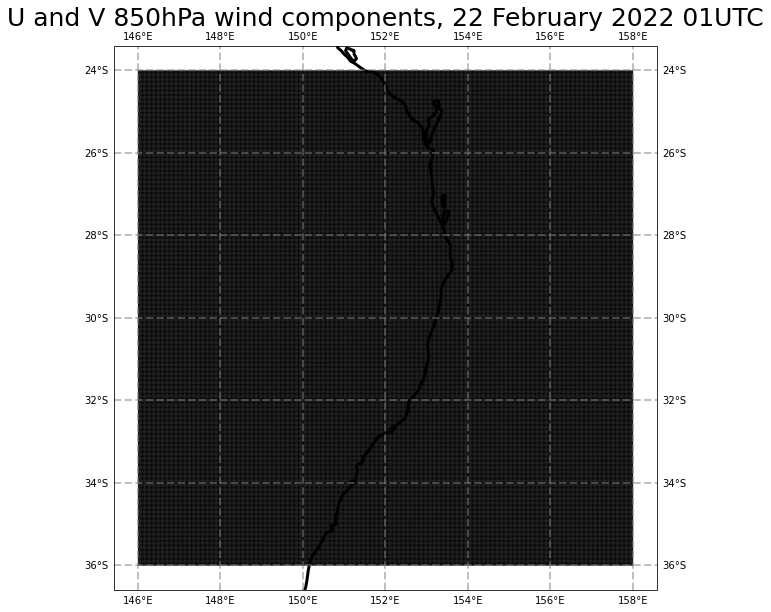

In [42]:
levels = np.arange(2,15,0.2)
plt.figure(figsize=(10, 10))
levels = np.arange(-20,20,2)
src = ccrs.PlateCarree()
ax = plt.axes(projection=src)
cmap=matplotlib.cm.get_cmap('Spectral_r')
#ch = ax.contourf(lon2d, lat2d, np.sqrt(np.squeeze(v)**2 + np.squeeze(u)**2), levels=levels,colors='k')
ax.quiver(longitude, latitude, np.squeeze(u), np.squeeze(v))
#ax.clabel(ch, ch.levels, inline=True, fontsize=20)
title = 'U and V 850hPa wind components, 22 February 2022 01UTC'
plt.title(title, size=25)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
ax.coastlines('50m', linewidth=3)

In [32]:
ncfile = Dataset('vorticity_divergence_data.nc','w')
nlon = len(longitude)
nlat = len(latitude)
ncfile.createDimension('longitude',nlon)
ncfile.createDimension('latitude',nlat)
ncfile.summary = 'U and V 850hPa wind components, 30 March 2022 00UTC'
ncfile.creator_name = 'Claire Vincent'
ncfile.date_created = '11 August 2022'
# Define the coordinate variables. They will hold the coordinate
# information, that is, the latitudes and longitudes.
# Coordinate variables only given for lat and lon.
latsnc = ncfile.createVariable('latitude',np.float32,('latitude',))
lonsnc = ncfile.createVariable('longitude',np.float32,('longitude',))
# Variables
unc = ncfile.createVariable('U', np.float32,('latitude','longitude'),zlib=True)
vnc = ncfile.createVariable('V', np.float32,('latitude','longitude'),zlib=True)

unc[:,:] = np.squeeze(u)[:,:]
vnc[:,:] = np.squeeze(v)[:,:]

lonsnc[:] = longitude[:]
latsnc[:] = latitude[:]

ncfile.close()

You can use the xarray to_netcdf() function to save a dataset or an array to netcdf. You can also compress the data passing the `encoding` dictionary. See below for an example.

In [ ]:
encoding = {}
for var in ['U', 'V']:
    encoding[var] = {
          'zlib': True, # Turn on compression
        'shuffle': True, # Turn on shuffle filter
         'complevel': 5, # Compression amount (0-9), 5 is a good compromise
         'dtype': 'float32',
        'chunksizes': [12, 212, 260]}

In [ ]:
outds = xr.merge(['U', 'V'])
# You can change/add also attributes
# It will automatically save all the coordinates attached to the variables
outds.to_netcdf('outfile.nc', encoding=encoding)